## Importing Redquired Libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import matplotlib.patches as patches
from dataset import CardiacDataset
from model import CardiacDetectionModel
import warnings
warnings.filterwarnings("ignore")
from torchinfo import summary


## Creating Train and Validation Loader

In [2]:
train_dataset = CardiacDataset("rsna_heart_detection.csv", "train_subjects.npy", "Processed_Heart_Detection/train", 0.49, 0.25)
val_dataset = CardiacDataset("rsna_heart_detection.csv", "val_subjects.npy", "Processed_Heart_Detection/val", 0.49, 0.25)

batch_size = 8
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)


## Model Instantiation 

In [18]:
model = CardiacDetectionModel()
print(summary(model, (batch_size, 1, 224, 224)))
_ = model.double()

Layer (type:depth-idx)                        Output Shape              Param #
CardiacDetectionModel                         [8, 4]                    --
├─ResNet: 1-1                                 [8, 4]                    --
│    └─Conv2d: 2-1                            [8, 64, 112, 112]         3,136
│    └─BatchNorm2d: 2-2                       [8, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [8, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [8, 64, 56, 56]           --
│    └─Sequential: 2-5                        [8, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [8, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [8, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [8, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [8, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [8, 128, 28, 28]        

## Model Training

In [ ]:
max_epochs = 100
loss_history = {'train': [], 'val': []}
model_dir = Path("saved_models")

In [6]:

for epoch in range(10, max_epochs):
    train_loss = 0
    model.train()

    for k, (images, y_true) in enumerate(train_loader):
        print(f"Batch Step = {k+1:02}",end="\r")
        model.optimizer.zero_grad()
        y_pred = model(images)
        loss = model.loss(y_true, y_pred)
        train_loss += loss.detach()
        loss.backward()
        model.optimizer.step()
    
    train_loss_avg = train_loss/len(train_loader)
    model.eval()
    val_loss = 0

    for images, y_true in val_loader:
        y_pred = model(images)
        loss = model.loss(y_true, y_pred)
        val_loss += loss.detach()
    
    val_loss_avg = val_loss/len(val_loader)

    print(f"Epoch: {epoch:03} Training Loss: {train_loss_avg:.3f} Validation Loss: {val_loss_avg:.3f}")
    loss_history['train'].append(train_loss_avg)
    loss_history['val'].append(val_loss_avg)

    if (epoch+1) % 10 == 0:
        model_path = model_dir/(f"Cardiac_detection_model_{epoch}.pth")
        model.save_model(model_path = model_path)

Epoch: 010 Training Loss: 11609.141 Validation Loss: 11028.458
Epoch: 011 Training Loss: 11200.915 Validation Loss: 10516.661
Epoch: 012 Training Loss: 10804.633 Validation Loss: 10261.205
Epoch: 013 Training Loss: 10417.494 Validation Loss: 9857.550
Epoch: 014 Training Loss: 10049.312 Validation Loss: 9454.992
Epoch: 015 Training Loss: 9688.411 Validation Loss: 9150.771
Epoch: 016 Training Loss: 9340.582 Validation Loss: 8871.325
Epoch: 017 Training Loss: 8995.258 Validation Loss: 8358.119
Epoch: 018 Training Loss: 8668.440 Validation Loss: 8110.482
Epoch: 019 Training Loss: 8354.062 Validation Loss: 7751.917
Epoch: 020 Training Loss: 8048.108 Validation Loss: 7684.238
Epoch: 021 Training Loss: 7751.376 Validation Loss: 7254.357
Epoch: 022 Training Loss: 7461.832 Validation Loss: 6811.691
Epoch: 023 Training Loss: 7183.083 Validation Loss: 6667.405
Epoch: 024 Training Loss: 6911.525 Validation Loss: 6465.219
Epoch: 025 Training Loss: 6653.408 Validation Loss: 6382.146
Epoch: 026 Train

## Model Evaluation
Creating Function to grab the x_min, y_min location and the width and height of the bounding box

In [9]:
def get_image_data(y):
    y=y.detach().numpy()
    loc = (y[0],y[1])
    w = y[2] - y[0]
    h = y[3] - y[1]
    return loc, w, h

Evaluating Model by plotting few images from the validation data and getting the true bounding box(Green) as well the predicted bounding box(Red).

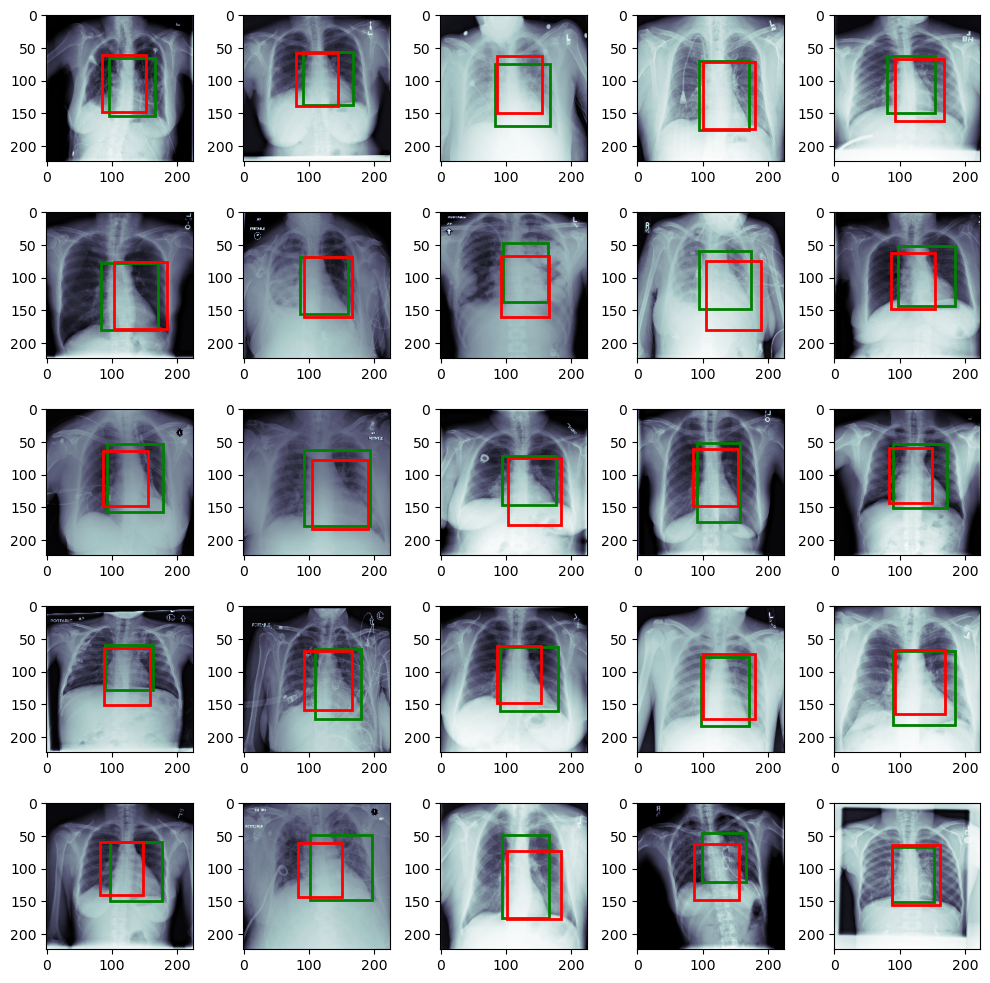

In [16]:
fig, ax = plt.subplots(5, 5, figsize = (10,10))
k = 0

for i in range(5):
    for j in range(5):
        img, y_true = val_dataset[k]
        y_pred = model(img.unsqueeze(0))
        y_pred = y_pred.squeeze(0)
        img = img.squeeze(0)
        ax[i,j].imshow(img, cmap = "bone")
        loc, w, h = get_image_data(y_true)
        rect1 = patches.Rectangle(loc, w, h, linewidth = 2, edgecolor = "g", facecolor = "none")
        loc, w, h = get_image_data(y_pred)
        rect2 = patches.Rectangle(loc, w, h, linewidth = 2, edgecolor = "r", facecolor = "none")
        ax[i,j].add_patch(rect1)
        ax[i,j].add_patch(rect2)
        k+=1
        ax[i,j].set_aspect("equal")

plt.tight_layout()



## Training and Validation Loss History
Saving train and validation loss history 

In [25]:
train_history = list(map(lambda x: x.item(), loss_history['train']))
val_history = list(map(lambda x: x.item(), loss_history['val']))
np.save("train_loss.npy", np.array(train_history))
np.save("validation_loss.npy", np.array(val_history))

Plotting train and validation loss for each epoch

Text(0.5, 1.0, 'Loss History')

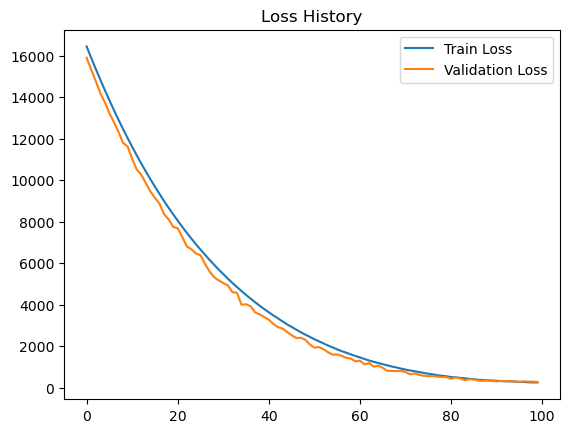

In [24]:
plt.plot(train_history, label = "Train Loss")
plt.plot(val_history, label = "Validation Loss")
plt.legend()
plt.title("Loss History")